<a href="https://colab.research.google.com/github/mattlamachado/King_County_DNC/blob/main/34012_Roof_Imoveis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# King County opção de investimento
5 imóveis que ela deveria investir e o porquê e quais 5 você não recomendaria o investimento de jeito nenhum.

In [18]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

roof = pd.read_csv('kingcounty/kc_house_data.csv')

In [14]:
roof.info()
roof_c = roof.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

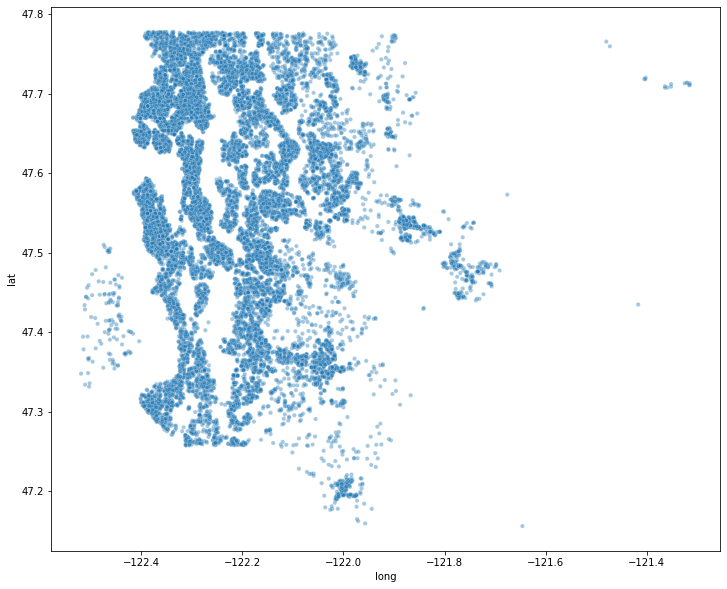

In [115]:
plt.figure(figsize=[12,10])
sns.scatterplot(x = roof_c['long'], y = roof_c['lat'], size=0.001, alpha=0.4, legend=False)
plt.show()

## Insights
- Encontre a cidade de cada imóvel;
- Calcule o preço por área de imóvel;
- Calcule o lucro/ perda de investimento caso o imóvel seja vendido mais de uma vez naquele período.


## Definição de Preço por pé<sup>2</sup>

In [17]:
roof_c['price_sqft'] = roof_c['price']/roof_c['sqft_living']
print(roof_c['price_sqft'])

0        188.050847
1        209.338521
2        233.766234
3        308.163265
4        303.571429
            ...    
21608    235.294118
21609    173.160173
21610    394.216667
21611    250.000000
21612    318.627451
Name: price_sqft, Length: 21613, dtype: float64


## Cálculo do Z score do \$/pé<sup>2</sup>
z-score = (valor - média)/desvpad

Neste caso o ideal era calcular o z-score baseade na média do valor do imóvel dentro de um raio de procura, tipo 5 km.


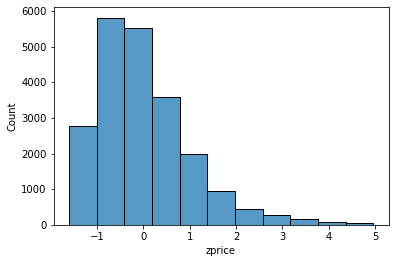

In [20]:
roof_c['zprice'] = pd.Series( (roof_c['price_sqft'] - (np.mean(roof_c['price_sqft']))) / np.std(roof_c['price_sqft']))

plt.figure()
sns.histplot(roof_c['zprice'], bins=11)
plt.show()

## Cálculo do Score da diferença do tamanho do imóvel em relação a vizinhança
Quão discrepante for o imóvel, para mais ou para menos em relação a vizinhança, menor vai ser o score final, assumindo que nenhum comprador queira adquirir um imóvel fora dos padrões da vizinhança.

O Valor foi elevado ao quadrado para o efeito da discrepância não ser linear.

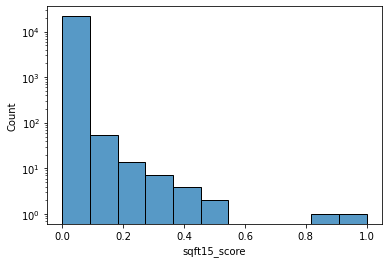

In [30]:
roof_c['sqft15_score'] = np.abs(roof_c['sqft_living'] - roof_c['sqft_living15'])**2
roof_c['sqft15_score'] /= max(roof_c['sqft15_score'])

plt.figure()
sns.histplot(roof_c['sqft15_score'], bins=11)
plt.yscale('log')
plt.show()

## Contrução do Score do imóvel

Dividindo as variáves pelos seus ranges, trazendo todas para a mesma escala entre 0-1:

$Score = Log10(( ('waterfront') + ('view'/4) + ('condition'/5) + ('grade'/13) + (('yr\_built' - 1900)/115) + (('yr\_renovated' - 1900)/115)*0.5 - ('sqft15_score') ) / ('zprice' + 1.6043173847341129))$

As variáveis do numerador ***aumentam o grau de atratividade*** de investimento em um imóvel, exceto ***'sqft15_score'*** o ***z-score*** representa quão distante da média o \$/m<sup>2</sup> está em relação ao King County em geral. ***Dividindo o score pelo z-score***, os imóveis com maiores valores de z-score, ou seja, com ***\$/m<sup>2</sup> muito acima da média, estão superprecificadas e tem seu score reduzido proporcionalmente***, reduzindo a tratividade de investimento.

In [73]:
roof_c['SCORE'] = (( (roof_c['waterfront']) + (roof_c['view']/4) + (roof_c['condition']/5) + (roof_c['grade']/13) + ((roof_c['yr_built'] - 1900)/115) + ((roof_c['yr_renovated'])/2015)*0.5 - (roof_c['sqft15_score'])) / (roof_c['zprice'] + 2.604317384734113))

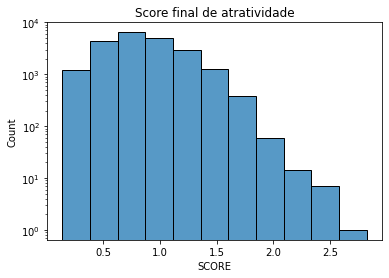

In [81]:
plt.figure()
plt.title('Score final de atratividade')
sns.histplot(roof_c['SCORE'], bins=11)
plt.yscale('log')
plt.show()

## 5 imóveis mais atrativos para investimento

In [75]:
display(roof_c.sort_values('SCORE', axis=0, ascending=False, inplace=False).head())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_sqft,zprice,sqft15_score,SCORE
8450,121039042,20150313T000000,425000.0,3,2.75,3610,107386,1.5,1,3,...,1962,98023,47.3351,-122.362,2630,42126,117.728532,-1.330460,0.012718,2.822950
3204,4136980090,20150407T000000,537000.0,4,4.25,4883,26040,2.0,0,3,...,0,98092,47.2630,-122.216,3736,9870,109.973377,-1.400924,0.017422,2.512518
1178,7893800335,20150430T000000,328000.0,4,3.25,3380,7500,2.0,0,3,...,0,98198,47.4092,-122.330,1920,7500,97.041420,-1.518425,0.028227,2.433798
13965,8141310180,20141118T000000,277500.0,3,2.50,2620,4558,2.0,0,3,...,0,98022,47.1944,-121.974,1670,4558,105.916031,-1.437789,0.011951,2.428602
21050,2424059170,20150219T000000,900000.0,5,6.00,7120,40806,2.0,0,4,...,0,98006,47.5451,-122.114,3440,36859,126.404494,-1.251629,0.179331,2.420499


## 5 imóveis menos atrativos para investimento

In [84]:
display(roof_c.sort_values('SCORE', axis=0, ascending=True, inplace=False).head())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_sqft,zprice,sqft15_score,SCORE
12757,2767603026,20150415T000000,425000.0,2,1.00,540,2500,1.0,0,0,...,0,98107,47.6729,-122.383,1290,5000,787.037037,4.750943,0.007449,0.138764
8623,6303400395,20150130T000000,325000.0,1,0.75,410,8636,1.0,0,0,...,0,98146,47.5077,-122.357,1190,8636,792.682927,4.802242,0.008057,0.156686
14055,369000365,20150422T000000,510000.0,1,1.00,680,6600,1.0,0,0,...,0,98199,47.6567,-122.392,1170,5500,750.000000,4.414421,0.003179,0.159654
7530,7228501745,20150219T000000,935000.0,4,2.00,1220,7489,2.0,0,0,...,0,98122,47.6133,-122.306,1220,3750,766.393443,4.563373,0.000000,0.162472
9294,1257201095,20150323T000000,826000.0,2,1.00,1060,6120,1.0,0,0,...,0,98103,47.6739,-122.329,1730,4080,779.245283,4.680146,0.005944,0.165020


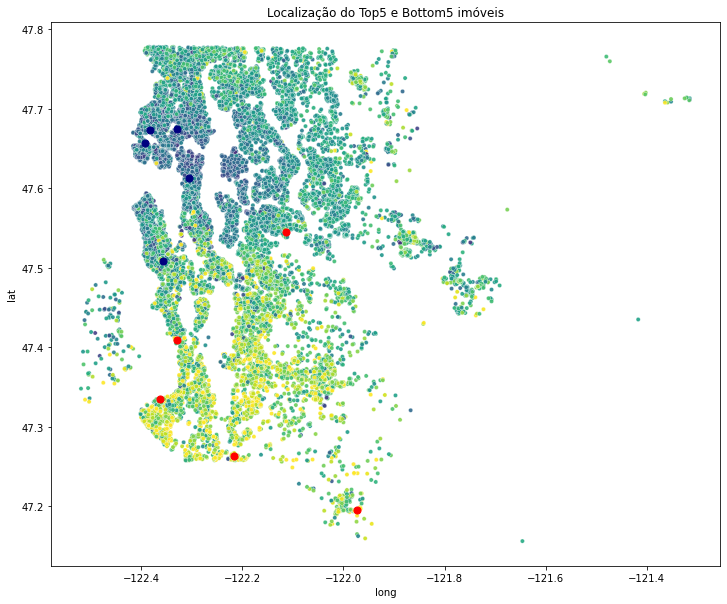

In [134]:
top5 = roof_c.sort_values('SCORE', axis=0, ascending=False, inplace=False).head()
bottom5 = roof_c.sort_values('SCORE', axis=0, ascending=True, inplace=False).head()

plt.figure(figsize=[12,10])
plt.title('Localização do Top5 e Bottom5 imóveis')
sns.scatterplot(x = roof_c['long'], y = roof_c['lat'], size=0.001, 
alpha=0.9, legend=False, hue=roof_c['SCORE'], palette='viridis', hue_norm=(0,1.5))

plt.scatter(top5['long'], top5['lat'], c = 'red', s = 50)
plt.scatter(bottom5['long'], bottom5['lat'], c = 'navy', s = 50)

plt.show()